# <a id='top'>Covid-19 Data Analysis</a>

The purpose of this project is to clean, explore, and draw insights from the Johns Hopkins COVID-19 dataset ([source](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker)) and the State and Policy Orders dataset ([source](https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders)).

### Table of Contents


* 1 [data cleaning](#cleaning)<br>
    * 1.1 [Johns Hopkins](#jh)<br>
    * 1.2 [State and Policy Orders](#sp)<br> 
* 2 [data visualization](#viz)<br>
    * 2.1 [New Cases and Deaths](#2.1)<br>
    * 2.2 [Policy Data Overlay](#2.2)<br>
* 3 [correlation between cases and policies](#corr)<br>
    * 3.1 [Finding Correlations](#3.1)<br>
    * 3.2 [Evaluating Correlations](#3.2)<br>
    * 3.3 [Discussion](#3.3)<br>
* 4 [Conclusion](#4)<br>

**important notes:**<br>
When investigating the new case and death numbers by location, we will control for county / state population by reporting these figures per 100,000 people. These will be called the *normalized* values.

**Associated links:**<br>
- [Data cleaning](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/main/Covid-19%20data%20cleaning.ipynb)

- [Github repo](https://github.com/apalermo01/covid-19-data-analysis)

# 0 Imports and configurations

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
# configuration settings
%reset -f
%config InlineBackend.figure_format = 'svg'

# basics 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from ipywidgets import interact, Dropdown, SelectMultiple, fixed

# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# miscellaneous
import re
from tabulate import tabulate
from IPython.display import clear_output
import us
import requests

# 1. <a id='cleaning'>Data Cleaning</a>

[back to top](#top)

Load each of the datasets. df = Johns Hopkins COVID-19 dataset, df2 = policy dataset. df is queried directly from dataworld. The policy dataset is collected by examining the source HTML on [data.gov](https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders)

In [3]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')

In [4]:
html = requests.get("https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders").text
policy_file = html.split("a href=\"/dataset/covid-19-state-and-county-policy-orders")[1]\
    .split("<span>plotly</span>")[0]\
    .split("https://plot.ly/external/?url=")[1]\
    .split("\">")[0]
df2 = pd.read_csv(policy_file)

In [5]:
print("Johns Hopkins datset (raw): ")
df.head()

Johns Hopkins datset (raw): 


uid location_type  fips_code location_name        state        date  \
0  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-22   
1  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-23   
2  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-24   
3  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-25   
4  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-26   

   total_population  cumulative_cases  cumulative_cases_per_100_000  \
0           18181.0                 0                           0.0   
1           18181.0                 0                           0.0   
2           18181.0                 0                           0.0   
3           18181.0                 0                           0.0   
4           18181.0                 0                           0.0   

   cumulative_deaths  cumulative_deaths_per_100_000  new_cases  new_deaths  \
0                  0                            0.0        NaN         NaN   
1                  0                            0.0        0.0         0.0   
2                  0                            0.0        0.0         0.0   
3                  0                            0.0        0.0         0.0   
4                  0                            0.0        0.0         0.0   

   new_cases_per_100_000  new_deaths_per_100_000  new_cases_7_day_rolling_avg  \
0                    NaN                     NaN                          NaN   
1                    0.0                     0.0                          NaN   
2                    0.0                     0.0                          NaN   
3                    0.0                     0.0                          NaN   
4                    0.0                     0.0                          NaN   

   new_deaths_7_day_rolling_avg  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN

In [6]:
print("State and Policy orders dataset (raw): ")
df2.head()

State and Policy orders dataset (raw): 


state_id   county  fips_code policy_level        date  \
0       MS    Hinds    28049.0       county  2020-07-13   
1       AZ      NaN        NaN        state  2020-05-16   
2       OR      NaN        NaN        state  2020-05-15   
3       ND  Pembina    38067.0       county  2020-09-03   
4       OR     Lane    41039.0       county  2020-05-15   

                policy_type start_stop  \
0             Entertainment      start   
1         Houses of Worship      start   
2  Non-Essential Businesses      start   
3                   Phase 5      start   
4                 New Phase      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
3  Policy_Details: - Most normal activity can res...   
4  Policy_Details: Gatherings up to 25 people all...   

                                              source  total_phases  
0  sip_submission_form: https://www.sos.ms.gov/co...           NaN  
1  sip_submission_form: https://azgovernor.gov/si...           NaN  
2  sip_submission_form: https://govstatus.egov.co...           NaN  
3  sip_submission_form: https://ndresponse.gov/si...           5.0  
4  sip_submission_form: https://www.eugene-or.gov...           NaN

## 1.1 <a id='jh'>Johns Hopkins Covid-19 dataset</a>

[back to top](#top)

Shorten some column names.

In [7]:
df.rename(columns={
    'cumulative_cases_per_100_000'  : 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000' : 'cumulative_deaths_1e6',
    'new_cases_per_100_000'         : 'new_cases_1e6', 
    'new_deaths_per_100_000'        : 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg'   : 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg'  : 'new_deaths_7day'
    }, inplace=True)

print("shortened column names: ")
df.head()

shortened column names: 


uid location_type  fips_code location_name        state        date  \
0  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-22   
1  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-23   
2  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-24   
3  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-25   
4  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-26   

   total_population  cumulative_cases  cumulative_cases_1e6  \
0           18181.0                 0                   0.0   
1           18181.0                 0                   0.0   
2           18181.0                 0                   0.0   
3           18181.0                 0                   0.0   
4           18181.0                 0                   0.0   

   cumulative_deaths  cumulative_deaths_1e6  new_cases  new_deaths  \
0                  0                    0.0        NaN         NaN   
1                  0                    0.0        0.0         0.0   
2                  0                    0.0        0.0         0.0   
3                  0                    0.0        0.0         0.0   
4                  0                    0.0        0.0         0.0   

   new_cases_1e6  new_deaths_1e6  new_cases_7day  new_deaths_7day  
0            NaN             NaN             NaN              NaN  
1            0.0             0.0             NaN              NaN  
2            0.0             0.0             NaN              NaN  
3            0.0             0.0             NaN              NaN  
4            0.0             0.0             NaN              NaN

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. 

Define a custom function to evaluate nulls and data types (df.info() gives similar information but we want more detailed info on datatypes)

In [8]:
def eval_df(df):
    """Count the number of nulls and list datatypes present in each column in the input DataFrame."""
    
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
        
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))

In [9]:
df.describe()

uid     fips_code  total_population  cumulative_cases  \
count  1.237656e+06  1.233946e+06      1.194620e+06      1.237656e+06   
mean   8.352961e+07  3.310136e+04      1.013323e+05      1.878638e+03   
std    3.206731e+06  1.861217e+04      3.260459e+05      1.064417e+04   
min    6.307200e+07  1.001000e+03      7.500000e+01      0.000000e+00   
25%    8.401811e+07  1.908500e+04      1.121425e+04      2.000000e+00   
50%    8.402921e+07  3.101800e+04      2.595050e+04      1.090000e+02   
75%    8.404612e+07  4.713300e+04      6.655225e+04      8.190000e+02   
max    8.410000e+07  9.999900e+04      1.009805e+07      1.085488e+06   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
count          1.194620e+06       1.237656e+06           1.194620e+06   
mean           1.818969e+03       4.588451e+01           3.570303e+01   
std            2.687558e+03       2.780091e+02           6.170480e+01   
min            0.000000e+00       0.000000e+00           0.000000e+00   
25%            2.245000e+01       0.000000e+00           0.000000e+00   
50%            4.979300e+02       1.000000e+00           6.310000e+00   
75%            2.625750e+03       1.600000e+01           4.695000e+01   
max            3.136767e+04       1.561400e+04           8.400200e+02   

          new_cases    new_deaths  new_cases_1e6  new_deaths_1e6  \
count  1.234320e+06  1.234320e+06   1.191400e+06    1.191400e+06   
mean   2.060690e+01  3.443977e-01   2.133155e+01    3.838989e-01   
std    1.432826e+02  5.371178e+00   5.561016e+01    2.604654e+00   
min   -7.590000e+03 -3.962000e+03  -5.975850e+03   -1.685400e+02   
25%    0.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
50%    1.000000e+00  0.000000e+00   2.970000e+00    0.000000e+00   
75%    9.000000e+00  0.000000e+00   2.380000e+01    0.000000e+00   
max    2.942300e+04  1.553000e+03   9.370100e+03    2.793300e+02   

       new_cases_7day  new_deaths_7day  
count    1.217150e+06     1.220232e+06  
mean     2.073590e+01     3.590907e-01  
std      1.304126e+02     2.550238e+00  
min      0.000000e+00     0.000000e+00  
25%      0.000000e+00     0.000000e+00  
50%      1.710000e+00     0.000000e+00  
75%      1.000000e+01     1.400000e-01  
max      1.607743e+04     2.445700e+02

In [10]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  --------------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                     3710  {<class 'numpy.float64'>}
location_name                  742  {<class 'str'>, <class 'float'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population             43036  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6         43036  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6        43036  {<class 'numpy.float64'>}
new_cases                     3336  {<class 'numpy.float64'>}
new_deaths                    3336  {<class 'numpy.float64'>}
new_cases_1e6                46256  {<class 'numpy.float64'>}
new_deaths_1e6               46256  {<class 'n

While inspecting these tables a few issues become apparent: 

1) null values in most columns

2) some fields that should be integers are floats (total_population, new_cases, new_deaths)

3) some values for location_name are floats

4) negative values in new_cases, new_deaths, and their normalized equivalents 

Some of these issues may be eliminated by throwing out some locations that are not a 'county' and locations not in the 50 states. 

In [11]:
print("unique location types:")
df['location_type'].unique()

unique location types:


array(['county', 'special_exception', 'out_of_state',
       'count_unassigned_to_location'], dtype=object)

In [12]:
df = df.drop(df[df['location_type']!='county'].index) # drop location_types that are not counties

states = [elem.name for elem in us.states.STATES]     # get list of u.s. states
df = df.drop(df[~df['state'].isin(states)].index)     # drop anything not in one of the 50 states (also drops DC)

In [13]:
print("data evaluation after dropping locations that are not counties or not in the 50 states")
eval_df(df)

data evaluation after dropping locations that are not counties or not in the 50 states
field                    num_nulls  datatypes
---------------------  -----------  -------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.float64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population                 0  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                     3141  {<class 'numpy.float64'>}
new_deaths                    3141  {<class 'numpy.float64'>}
new_cases_1e6                 3141  {<class '

Restricting locations had the effect of throwing out nulls in fips_code, location_name, total_poplulation, cumulative_cases_1e6, and cumulative_deaths_1e6. 

Make the locations more consistent by converting 'location_name' to 'county' (this will ensure consistency with the policy dataset) and make a new column with the combined county and state name. 

In [14]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df['location_name'] = df['location_name'].str.lower()

# re-order columns
cols = df.columns.tolist()
cols = cols[:6] + [cols[-1]] + cols[6:-1]
df = df[cols]

df.rename(columns={'location_name' : 'county'}, inplace=True)

print("df after adjusting location columns")
df.head()

df after adjusting location columns


uid location_type  fips_code   county    state        date  \
29680  84001001        county     1001.0  autauga  Alabama  2020-01-22   
29681  84001001        county     1001.0  autauga  Alabama  2020-01-23   
29682  84001001        county     1001.0  autauga  Alabama  2020-01-24   
29683  84001001        county     1001.0  autauga  Alabama  2020-01-25   
29684  84001001        county     1001.0  autauga  Alabama  2020-01-26   

          full_loc_name  total_population  cumulative_cases  \
29680  Autauga, Alabama           55200.0                 0   
29681  Autauga, Alabama           55200.0                 0   
29682  Autauga, Alabama           55200.0                 0   
29683  Autauga, Alabama           55200.0                 0   
29684  Autauga, Alabama           55200.0                 0   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
29680                   0.0                  0                    0.0   
29681                   0.0                  0                    0.0   
29682                   0.0                  0                    0.0   
29683                   0.0                  0                    0.0   
29684                   0.0                  0                    0.0   

       new_cases  new_deaths  new_cases_1e6  new_deaths_1e6  new_cases_7day  \
29680        NaN         NaN            NaN             NaN             NaN   
29681        0.0         0.0            0.0             0.0             NaN   
29682        0.0         0.0            0.0             0.0             NaN   
29683        0.0         0.0            0.0             0.0             NaN   
29684        0.0         0.0            0.0             0.0             NaN   

       new_deaths_7day  
29680              NaN  
29681              NaN  
29682              NaN  
29683              NaN  
29684              NaN

Convert 'date' to datetime. 

In [15]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Handle negative and null values in numerical columns. 

The nulls in new_cases(\_1e6) and new_deaths(\_1e6) all occur on 2020-01-22, the first day on which reporting occurs, so set those to 0.

The negative values in these columns can also be set to zero. On the [disucssion page](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) for this dataset in dataworld  user nickyforester adressed the negative values in new_cases and new_deaths with the following comment: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

For those interested, I started an in-depth analysis on how these negative values are distributed in the data_cleaning notebook. 

Additionally, cast all these columns to integers. 

In [16]:
cols = ['new_cases', 'new_deaths', 'new_cases_1e6', 'new_deaths_1e6']

for col in cols: 
    df[col].fillna(value=0, inplace=True)
    df[col].clip(lower=0, inplace=True)

cols2 = ["fips_code", "total_population", "new_cases", "new_deaths"]
df[cols2] = df[cols2].astype(np.int64)

print("set nulls to zero and any value < 0 to 0")
df.head()

set nulls to zero and any value < 0 to 0


uid location_type  fips_code   county    state       date  \
29680  84001001        county       1001  autauga  Alabama 2020-01-22   
29681  84001001        county       1001  autauga  Alabama 2020-01-23   
29682  84001001        county       1001  autauga  Alabama 2020-01-24   
29683  84001001        county       1001  autauga  Alabama 2020-01-25   
29684  84001001        county       1001  autauga  Alabama 2020-01-26   

          full_loc_name  total_population  cumulative_cases  \
29680  Autauga, Alabama             55200                 0   
29681  Autauga, Alabama             55200                 0   
29682  Autauga, Alabama             55200                 0   
29683  Autauga, Alabama             55200                 0   
29684  Autauga, Alabama             55200                 0   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
29680                   0.0                  0                    0.0   
29681                   0.0                  0                    0.0   
29682                   0.0                  0                    0.0   
29683                   0.0                  0                    0.0   
29684                   0.0                  0                    0.0   

       new_cases  new_deaths  new_cases_1e6  new_deaths_1e6  new_cases_7day  \
29680          0           0            0.0             0.0             NaN   
29681          0           0            0.0             0.0             NaN   
29682          0           0            0.0             0.0             NaN   
29683          0           0            0.0             0.0             NaN   
29684          0           0            0.0             0.0             NaN   

       new_deaths_7day  
29680              NaN  
29681              NaN  
29682              NaN  
29683              NaN  
29684              NaN

In the 7 day running averages, most of the nulls occur in the first few days, so set those to zero. 

There are additional nulls distributed throughout the dataset. Loop through these nulls and re-calculate the 7-day running average.

In [17]:
# Start timer. 
start = time.time()

# Set rolling averages to zero in the first few days of measurements.
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0)
    )

# Get dataframes where normalized new_cases and new_deaths are null
nulls_case7day = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]

# Pre-define timedelta for efficiency. 
days_7 = timedelta(days=7)

# Prepare some outputs since this function will take a while. 
i = 0
num_elem = len(nulls_case7day)
msg = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

# Loop through nulls in new_cases_7day
for index, data in nulls_case7day.iterrows():
    
    # Output for inpatient people like me. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
        
    if i%250 == 0: 
        clear_output()
        print(msg)
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at the datapoint of interest
    df.loc[index, ['new_cases_7day']] = np.sum((
        [df['new_cases'][(df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7
    
# Reset output. 
clear_output()
print("Looping through nulls in new_deaths_7day. Please be patient, this may take a while")
i = 0
num_elem = len(nulls_death7day)

# Loop through nulls in new_deaths_7day
for index, data in nulls_death7day.iterrows():
    
    # Output status. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at datapoint of interest. 
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7

# Output complete. 
clear_output()
print("re-calculation of running averages complete.")
end = time.time()
print(f"time elapsed: {end-start}")
df.head()

re-calculation of running averages complete.
time elapsed: 86.39142322540283


uid location_type  fips_code   county    state       date  \
29680  84001001        county       1001  autauga  Alabama 2020-01-22   
29681  84001001        county       1001  autauga  Alabama 2020-01-23   
29682  84001001        county       1001  autauga  Alabama 2020-01-24   
29683  84001001        county       1001  autauga  Alabama 2020-01-25   
29684  84001001        county       1001  autauga  Alabama 2020-01-26   

          full_loc_name  total_population  cumulative_cases  \
29680  Autauga, Alabama             55200                 0   
29681  Autauga, Alabama             55200                 0   
29682  Autauga, Alabama             55200                 0   
29683  Autauga, Alabama             55200                 0   
29684  Autauga, Alabama             55200                 0   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
29680                   0.0                  0                    0.0   
29681                   0.0                  0                    0.0   
29682                   0.0                  0                    0.0   
29683                   0.0                  0                    0.0   
29684                   0.0                  0                    0.0   

       new_cases  new_deaths  new_cases_1e6  new_deaths_1e6  new_cases_7day  \
29680          0           0            0.0             0.0             0.0   
29681          0           0            0.0             0.0             0.0   
29682          0           0            0.0             0.0             0.0   
29683          0           0            0.0             0.0             0.0   
29684          0           0            0.0             0.0             0.0   

       new_deaths_7day  
29680              0.0  
29681              0.0  
29682              0.0  
29683              0.0  
29684              0.0

Make a few new columns normalized 7 day rolling averages. 

In [18]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population'] / 1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population'] / 1e5)

print("Calculated normalized 7-day rolling averages.")
df.head()

Calculated normalized 7-day rolling averages.


uid location_type  fips_code   county    state       date  \
29680  84001001        county       1001  autauga  Alabama 2020-01-22   
29681  84001001        county       1001  autauga  Alabama 2020-01-23   
29682  84001001        county       1001  autauga  Alabama 2020-01-24   
29683  84001001        county       1001  autauga  Alabama 2020-01-25   
29684  84001001        county       1001  autauga  Alabama 2020-01-26   

          full_loc_name  total_population  cumulative_cases  \
29680  Autauga, Alabama             55200                 0   
29681  Autauga, Alabama             55200                 0   
29682  Autauga, Alabama             55200                 0   
29683  Autauga, Alabama             55200                 0   
29684  Autauga, Alabama             55200                 0   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
29680                   0.0                  0                    0.0   
29681                   0.0                  0                    0.0   
29682                   0.0                  0                    0.0   
29683                   0.0                  0                    0.0   
29684                   0.0                  0                    0.0   

       new_cases  new_deaths  new_cases_1e6  new_deaths_1e6  new_cases_7day  \
29680          0           0            0.0             0.0             0.0   
29681          0           0            0.0             0.0             0.0   
29682          0           0            0.0             0.0             0.0   
29683          0           0            0.0             0.0             0.0   
29684          0           0            0.0             0.0             0.0   

       new_deaths_7day  new_cases_7day_1e6  new_deaths_7day_1e6  
29680              0.0                 0.0                  0.0  
29681              0.0                 0.0                  0.0  
29682              0.0                 0.0                  0.0  
29683              0.0                 0.0                  0.0  
29684              0.0                 0.0                  0.0

Re-check the data to see if there are any missed issues.

In [19]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  ----------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.int64'>}
county                           0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'numpy.datetime64'>}
full_loc_name                    0  {<class 'str'>}
total_population                 0  {<class 'numpy.int64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                        0  {<class 'numpy.int64'>}
new_deaths                       0  {<class 'numpy.int64'>}
new_cases_1e6                    0  {<class 'numpy.float64'>}
new_deaths

## 1.2 <a id='sp'>State and Policy Orders</a>

[back to top](#top)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| state_id | state name | string
| county | county name (this should be the same as county in the Johns Hopkins dataset) | string, county name for county level policies "statewide" for state policies
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| policy_level | scope of policy | string, 'county' or 'state
| date | date of policy implementation | datetime object
| policy_type | brief description of policy classification | datetime object
| start_stop | whether this is the start of a restriction or lifting of a restriction | 'start' or 'stop' (string)
| comments | additional information | string
| source | source for policy info | string
| total_phases | total number of phases | positive integer

Since this is mostly text-based data, skip .describe().

In [20]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1676  {<class 'str'>, <class 'float'>}
fips_code            1676  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2937  {<class 'numpy.float64'>}


Data cleaning for the policy dataset is somewhat more straightforward: 

1) drop policies not implemented in the 50 states

2) convert state abbreviations to the full name 

3) re-name 'state_id' to 'state'

4) drop total_phases since we won't be using it 

5) nulls in 'county' are statewide policies, so fill nulls with 'statewide'

6) convert 'county' to lowercase

7) convert 'date' from int to datetime

In [21]:
print("original policy data:")

df2.head()

original policy data:


state_id   county  fips_code policy_level        date  \
0       MS    Hinds    28049.0       county  2020-07-13   
1       AZ      NaN        NaN        state  2020-05-16   
2       OR      NaN        NaN        state  2020-05-15   
3       ND  Pembina    38067.0       county  2020-09-03   
4       OR     Lane    41039.0       county  2020-05-15   

                policy_type start_stop  \
0             Entertainment      start   
1         Houses of Worship      start   
2  Non-Essential Businesses      start   
3                   Phase 5      start   
4                 New Phase      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
3  Policy_Details: - Most normal activity can res...   
4  Policy_Details: Gatherings up to 25 people all...   

                                              source  total_phases  
0  sip_submission_form: https://www.sos.ms.gov/co...           NaN  
1  sip_submission_form: https://azgovernor.gov/si...           NaN  
2  sip_submission_form: https://govstatus.egov.co...           NaN  
3  sip_submission_form: https://ndresponse.gov/si...           5.0  
4  sip_submission_form: https://www.eugene-or.gov...           NaN

In [22]:
abbr = [elem.abbr for elem in us.states.STATES]

df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)                     
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)    
df2.rename(columns={'state_id' : 'state'}, inplace=True)                   
df2.drop('total_phases', axis=1, inplace=True)                             
df2['county'].fillna(value='statewide', inplace=True)                      
df2['county'] = df2['county'].str.lower()                                  
df2.loc[:, 'date'] = '2020' + df2['date'].str[4:] # some formatting issues in 'date': 0020 instead of 2020
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')  

print("policy data after initial cleaning")
df2.head()

policy data after initial cleaning


state     county  fips_code policy_level       date  \
0   Mississippi      hinds    28049.0       county 2020-07-13   
1       Arizona  statewide        NaN        state 2020-05-16   
2        Oregon  statewide        NaN        state 2020-05-15   
3  North Dakota    pembina    38067.0       county 2020-09-03   
4        Oregon       lane    41039.0       county 2020-05-15   

                policy_type start_stop  \
0             Entertainment      start   
1         Houses of Worship      start   
2  Non-Essential Businesses      start   
3                   Phase 5      start   
4                 New Phase      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
3  Policy_Details: - Most normal activity can res...   
4  Policy_Details: Gatherings up to 25 people all...   

                                              source  
0  sip_submission_form: https://www.sos.ms.gov/co...  
1  sip_submission_form: https://azgovernor.gov/si...  
2  sip_submission_form: https://govstatus.egov.co...  
3  sip_submission_form: https://ndresponse.gov/si...  
4  sip_submission_form: https://www.eugene-or.gov...

There are several mismatches between 'county' in df2 and 'location_name' in df. All of these end with a modifier- most of them end in 'county' (e.g. 'bronx county') and a few end in 'municipality' and 'borough'. Strip these off in df2. 

In [23]:
county_match  = re.compile(" county$")
munici_match  = re.compile(" municipality$")
Borough_match = re.compile(" borough$")

df2['county'].replace(to_replace=county_match,  value='', inplace=True)
df2['county'].replace(to_replace=munici_match,  value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

Nulls in fips_code relate to statewide polices, so replace the nulls with the 2 digit fips code for the state 

In [24]:
print("statewide policies before fips_code adjustment:")
df2[df2['policy_level']=='state'].head()

statewide policies before fips_code adjustment:


state     county  fips_code policy_level       date  \
1      Arizona  statewide        NaN        state 2020-05-16   
2       Oregon  statewide        NaN        state 2020-05-15   
5  Connecticut  statewide        NaN        state 2020-03-16   
6     Michigan  statewide        NaN        state 2020-03-16   
7      Indiana  statewide        NaN        state 2020-03-30   

                   policy_type start_stop  \
1            Houses of Worship      start   
2     Non-Essential Businesses      start   
5                         Gyms      start   
6                         Gyms      start   
7  Allow Audio Only Telehealth      start   

                                            comments  \
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
5  Other measures and details for this policy inc...   
6  Other measures and details for this policy inc...   
7  Other measures and details for this policy inc...   

                                              source  
1  sip_submission_form: https://azgovernor.gov/si...  
2  sip_submission_form: https://govstatus.egov.co...  
5                  BU COVID-19 State Policy Database  
6                  BU COVID-19 State Policy Database  
7                  BU COVID-19 State Policy Database

In [25]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state': 
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state).fips)
print("statewide policies after fips_code adjustment:")
df2[df2['policy_level']=='state'].head()

statewide policies after fips_code adjustment:


state     county  fips_code policy_level       date  \
1      Arizona  statewide        4.0        state 2020-05-16   
2       Oregon  statewide       41.0        state 2020-05-15   
5  Connecticut  statewide        9.0        state 2020-03-16   
6     Michigan  statewide       26.0        state 2020-03-16   
7      Indiana  statewide       18.0        state 2020-03-30   

                   policy_type start_stop  \
1            Houses of Worship      start   
2     Non-Essential Businesses      start   
5                         Gyms      start   
6                         Gyms      start   
7  Allow Audio Only Telehealth      start   

                                            comments  \
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
5  Other measures and details for this policy inc...   
6  Other measures and details for this policy inc...   
7  Other measures and details for this policy inc...   

                                              source  
1  sip_submission_form: https://azgovernor.gov/si...  
2  sip_submission_form: https://govstatus.egov.co...  
5                  BU COVID-19 State Policy Database  
6                  BU COVID-19 State Policy Database  
7                  BU COVID-19 State Policy Database

Convert fips_code to integers

In [26]:
df2['fips_code'] = df2['fips_code'].astype(np.int64)

print("converted fips_code to integers")
df2.head()

converted fips_code to integers


state     county  fips_code policy_level       date  \
0   Mississippi      hinds      28049       county 2020-07-13   
1       Arizona  statewide          4        state 2020-05-16   
2        Oregon  statewide         41        state 2020-05-15   
3  North Dakota    pembina      38067       county 2020-09-03   
4        Oregon       lane      41039       county 2020-05-15   

                policy_type start_stop  \
0             Entertainment      start   
1         Houses of Worship      start   
2  Non-Essential Businesses      start   
3                   Phase 5      start   
4                 New Phase      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
3  Policy_Details: - Most normal activity can res...   
4  Policy_Details: Gatherings up to 25 people all...   

                                              source  
0  sip_submission_form: https://www.sos.ms.gov/co...  
1  sip_submission_form: https://azgovernor.gov/si...  
2  sip_submission_form: https://govstatus.egov.co...  
3  sip_submission_form: https://ndresponse.gov/si...  
4  sip_submission_form: https://www.eugene-or.gov...

Examine all the policy types in this dataset.

In [27]:
print("all policy types in df2:")
df2['policy_type'].sort_values().unique()

all policy types in df2:


array(['Agriculture', 'Allow Audio Only Telehealth',
       'Allow Expand Medicaid Telehealth Coverage',
       'Alternative Care Facilities ', 'Bars', 'Childcare (K-12)',
       'Colleges & Universities', 'Construction', 'Day Care',
       'Day camps/overnight camps', 'Education', 'Election',
       'Entertainment', 'Executive Order', 'Food and Drink',
       'Froze Mortgage Payments', 'Gatherings', 'Graduation',
       'Graduation Ceremony guidelines', 'Gyms', 'Health Risk Status',
       'Houses of Worship',
       'Mandate Face Mask Use By All Individuals In Public Facing Businesses',
       'Mandate Face Mask Use By All Individuals In Public Spaces',
       'Manufacturing', 'Mask Requirement', 'Medical',
       'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval',
       'New Phase', 'Non-Essential Businesses',
       'Nursing Home Visitations', 'Nursing Homes',
       'Order Freezing Utility Shut Offs', 'Outdoor and Recreation',
       'Personal Care', 'Phase 1',

Drop vague / unrelated policies (e.g. 'Phase 1').

In [28]:
policies_drop = ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']
print(f"dropping policies: {policies_drop}")
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

dropping policies: ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']


Rename some long-winded policies and convert them all to lowercase.

In [29]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues'  : 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'  : 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues' : 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses' : 'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces'            : 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period'            : 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures'                         : 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage'                            : 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent'           : 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)
    
df2['policy_type'] = df2['policy_type'].str.lower()

print("all policy types in df2: ")
df2['policy_type'].sort_values().unique()

all policy types in df2: 


array(['aca special enrollment period', 'agriculture',
       'allow audio only telehealth', 'alternative care facilities ',
       'bars', 'childcare (k-12)', 'colleges & universities',
       'construction', 'day camps/overnight camps', 'day care',
       'education', 'election', 'entertainment', 'executive order',
       'expand medicaid telehealth coverage', 'food and drink',
       'froze mortgage payments', 'gatherings',
       'grace period / security deposit for rent', 'graduation',
       'graduation ceremony guidelines', 'gyms', 'health risk status',
       'higher education', 'houses of worship', 'libraries',
       'mandate face masks in businesses',
       'mandate face masks in public spaces', 'manufacturing',
       'mask requirement', 'medical', 'modify medicaid requirements',
       'museums', 'non-essential businesses', 'nursing home visitations',
       'nursing homes', 'order freezing utility shut offs',
       'outdoor and recreation', 'personal care', 'public gath

Drop policies that were enacted before the first date in the case dataset and policies scheduled in the future.

In [30]:
df2 = df2.drop(df2[(df2['date'] < min(df['date'])) | (df2['date'] > datetime.today())].index)
print("invalid dates dropped")

invalid dates dropped


Perform a final check. 

In [31]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  ----------------------------
state                   0  {<class 'str'>}
county                  0  {<class 'str'>}
fips_code               0  {<class 'numpy.int64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'numpy.datetime64'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}


Finally, export these datasets to csv files (these files will be used for future additions to this project, such as a tableau dashboard). 

In [32]:
df.to_csv("case_data_clean.csv")
df2.to_csv("policy_data_clean.csv")

# 2 <a id='viz'>Data visualizations</a>

[back to top](#top)

## 2.1 <a id='2.1'>New cases and deaths</a>

[back to top](#top)

Plot cases and deaths at the county, state, and national levels.

First, write a function to filter and aggregate the data as needed. 

In [33]:
def get_cases(level="county", county="orange", state="California", df=df):
    
    """ Return the new_case and new_death numbers at the given level of aggregation (county, state, or national). 
    
    Parameters
    ----------
    level : {'county', 'state', 'national'}
        If county, returns a DataFrame filtered to a specific county (default). 
        If state, aggregates the DataFrame to the state level. 
        If national, or any other input, returns the DataFrame aggregated to the national level. 
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    
    Returns 
    ----------
    DataFrame
        case_data filtered to a specific county or aggregated to the state / national level with index=date
    """
    # return county level data
    if level == "county":
        return_df = df[(df["county"] == county) & (df["state"] == state)].set_index("date")[['new_cases_1e6', 
                                                                                             'new_deaths_1e6', 
                                                                                             'new_cases_7day_1e6', 
                                                                                             'new_deaths_7day_1e6',
                                                                                            ]]
        
        return return_df
    
    # If this is filtered at the state level, filter df to desired state. Otherwise, return national-level data.
    if level == "state": 
        df = df[df['state'] == state]

    # Reindex on location name.
    df = df.set_index(["full_loc_name"])
    
    # Get a list of all dates.
    all_dates = df['date'].unique()

    # Get the total population from the county populations.
    total_population =  sum([(pops / 1e5) for pops in df[df['date'] == all_dates[0]]['total_population']]) 
    
    # Add up the case and death #s that have the same date.
    new_cases       = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_1e6']]) 
                              for dates in all_dates]

    new_deaths      = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                              for dates in all_dates]

    new_cases_7day  = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_7day_1e6']]) 
                              for dates in all_dates]

    new_deaths_7day = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_7day_1e6']]) 
                              for dates in all_dates]


    return_df = pd.DataFrame(data={'date'               : all_dates,
                                   'new_cases_1e6'      : new_cases, 
                                   'new_deaths_1e6'     : new_deaths,
                                   'new_cases_7day_1e6' : new_cases_7day,
                                   'new_deaths_7day_1e6': new_deaths_7day
                                   }).set_index(["date"]) 
    return return_df

In [34]:
print("Recent case data for Mecklenburg county, NC:")
get_cases(level="county", county="mecklenburg", state="North Carolina").tail()

Recent case data for Mecklenburg county, NC:


new_cases_1e6  new_deaths_1e6  new_cases_7day_1e6  \
date                                                            
2021-01-22          76.35            0.76           67.478000   
2021-01-23          84.98            0.66           67.342367   
2021-01-24          70.00            0.38           67.478000   
2021-01-25          66.11            0.19           76.922055   
2021-01-26          55.49            0.28           73.453449   

            new_deaths_7day_1e6  
date                             
2021-01-22             0.650660  
2021-01-23             0.596596  
2021-01-24             0.623154  
2021-01-25             0.650660  
2021-01-26             0.582369

In [35]:
print("Recent case data for North Carolina:")
get_cases(level="state", state="North Carolina").tail()

Recent case data for North Carolina:


new_cases_1e6  new_deaths_1e6  new_cases_7day_1e6  \
date                                                            
2021-01-22      79.754922        1.460078           61.674846   
2021-01-23      71.388720        1.278503           59.980419   
2021-01-24      60.112604        1.453185           59.037676   
2021-01-25      38.950241        0.321989           64.597923   
2021-01-26      38.823611        0.923922           60.137066   

            new_deaths_7day_1e6  
date                             
2021-01-22             0.836806  
2021-01-23             0.907166  
2021-01-24             1.017675  
2021-01-25             1.064968  
2021-01-26             1.077521

In [36]:
print("Recent case data for the United States:")
get_cases(level="national").tail()

Recent case data for the United States:


new_cases_1e6  new_deaths_1e6  new_cases_7day_1e6  \
date                                                            
2021-01-22      53.882841        1.137992           47.924930   
2021-01-23      47.047533        1.393436           47.013589   
2021-01-24      30.662178        0.587967           45.381948   
2021-01-25      29.692436        0.568347           45.153532   
2021-01-26      39.829550        1.398898           45.538611   

            new_deaths_7day_1e6  
date                             
2021-01-22             1.044155  
2021-01-23             1.090376  
2021-01-24             1.090529  
2021-01-25             1.105833  
2021-01-26             1.164708

Next, plot the data. 

In [37]:
def plot_cases(level="county", county="orange", state="California", df=df, fade=0.75, style="whitegrid", ax=None, fig=None):
    
    """ A function which plots the COVID-19 case/death data and 7 day average.
    
    Parameters
    ---------- 
    level : {'county', 'state', 'national'}
        Value to pass to get_cases()
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    style : string
        Seaborn plot style (default: "whitegrid")
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
        
    Returns 
    ----------
    matplotlib.figure.Figure
    ndarray containing the two axis handles
    pandas DataFrame
    """
    
    # Get the data. 
    cases = get_cases(level, county, state, df)
        
    # Set up plots. 
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style(style)
    
    # Plot cases.
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
        );

    # Plot deaths. 
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
        );
    
    # Format axis labels. 
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    # Set plot title based on level of aggregeation (county, state, or national)
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}");
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}");
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States")
    
    
    return fig, ax, cases

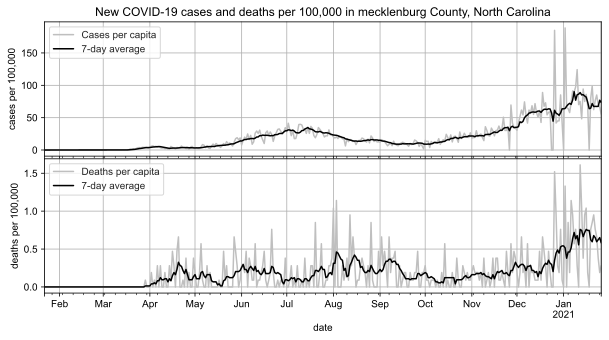

In [38]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

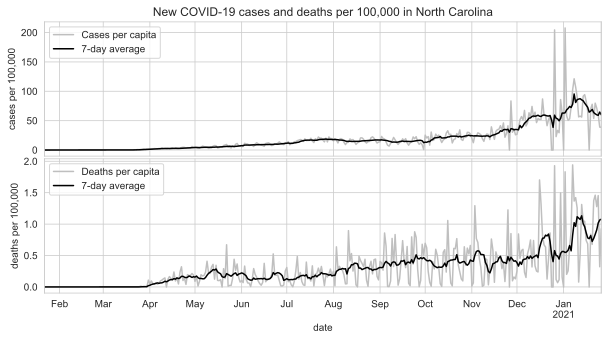

In [39]:
plot_cases(level="state", state="North Carolina");

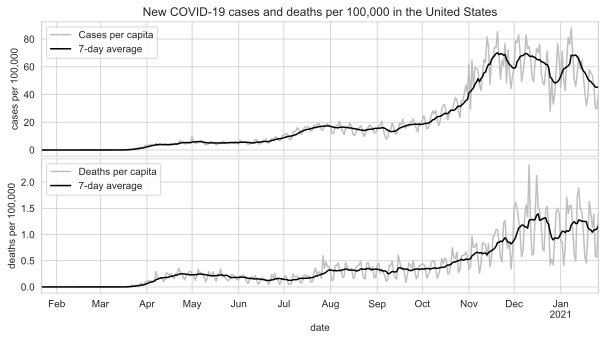

In [40]:
plot_cases(level="national");

## 2.2 <a id='2.2'>Policy data overlay</a>

[back to top](#top)<br>
First, get the policy data for a specific county at the state level, county level, or both. Then, make a plot that overlays policy enactments and case / death numbers with a few selected policies.

In [41]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
   
    """Get the policy data at county level, state level, or both.  

    Parameters
    ----------
    state : string 
        selected state
    county : string
        selected county
    state_policies : boolean 
        include policies at the state level (default: True)
    county_policies : boolean 
        include policies at the county level (default: True)
    
    Returns
    ---------- 
    filtered DataFrame
    """
    # state AND county policies
    if state_policies and county_policies:

        return df[(df['state'] == state) &
                  ((df["county"] == county) | (df["county"] == "statewide"))]
    
    # state policies only
    elif state_policies and not county_policies: 
        return df[ (df['state'] == state) & (df["county"] == "statewide")]
    
    # county policies only
    else:  
         return df[ (df['state'] == state) & (df["county"] == county)]

In [42]:
print("Recent policy data for Mecklenburg county, NC:")
get_policy_data(state="North Carolina", county="mecklenburg", state_policies=False).head()

Recent policy data for Mecklenburg county, NC:


state       county  fips_code policy_level       date  \
372   North Carolina  mecklenburg      37119       county 2020-04-29   
2460  North Carolina  mecklenburg      37119       county 2020-03-26   

           policy_type start_stop                         comments    source  
372   shelter in place       stop    Mecklenburg County Policy End  wikidata  
2460  shelter in place      start  Mecklenburg County Policy Start  wikidata

In [43]:
print("Recent policy data for North Carolina:")
get_policy_data(state="North Carolina",
                county="mecklenburg", 
                county_policies=False).sort_values(by='date', ascending=False).head()

Recent policy data for North Carolina:


state     county  fips_code policy_level       date  \
1897  North Carolina  statewide         37        state 2020-10-02   
2347  North Carolina  statewide         37        state 2020-10-02   
395   North Carolina  statewide         37        state 2020-10-02   
406   North Carolina  statewide         37        state 2020-10-02   
1387  North Carolina  statewide         37        state 2020-10-02   

                   policy_type start_stop  \
1897    outdoor and recreation       stop   
2347  non-essential businesses       stop   
395              entertainment       stop   
406             food and drink       stop   
1387            food and drink       stop   

                                               comments  \
1897  Policy_Details: *phase 2.5 \r\nGovernor Roy Co...   
2347  Policy_Details: *phase 2.5 \r\nGovernor Roy Co...   
395   Policy_Details: Governor Roy Cooper signed Exe...   
406   Policy_Details: Governor Roy Cooper signed Exe...   
1387  Policy_Details: *phase 2.5 \r\nGovernor Roy Co...   

                                                 source  
1897  sip_submission_form: https://files.nc.gov/gove...  
2347  sip_submission_form: https://files.nc.gov/gove...  
395   sip_submission_form: https://files.nc.gov/gove...  
406   sip_submission_form: https://files.nc.gov/gove...  
1387  sip_submission_form: https://files.nc.gov/gove...

In [44]:
def plot_cases_and_policies(
        county, state, 
        colors=sns.color_palette()[:],  
        policies=[
            "mandate face masks in public spaces", 
            "mandate face masks in businesses", 
            "shelter in place", 
            "state of emergency"],
                           
        labels=["face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"],
    ):

    
    """Plot the cases overlayed with the policies. 
    
    Parameters
    ---------- 
    county : string 
        county of interest
    state : string
        state of interest
    policies : array-like
        policies to plot (default: face mask mandates in public spaces and businesses, shelter in place, 
        and state of emergency)
    colors : array-like
        line colors for respective policies (in order) (default: k, b, r, g)
    labels : array-like 
        legend labels for the selected policies (default: "face mask mandate (public spaces)", 
        "face mask mandate (businesses)", "shelter in place", and "state of emergency")
    style : string 
        sns plot style (whitegrid by default, dark styles not recommended)
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
    
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    
    Returns
    ----------
    ndarray containing the two axis handles used for plotting
    """

    
    # Plot case / death data.
    plt.figure();
    fig, ax, df = plot_cases(level="county", county=county, state=state);

    # Get the policy data for the selected state and county.
    policy_data = get_policy_data(state, county);

    # Set a solid line to be the start of a policy and a dashed line to be the end.
    styles_start_stop = {
        "start" : '-', 
        "stop" : ':'
    }

    # Set color codes for selected policies.
    styles_policy_type = {policies[i] : colors[i] for i in range(len(policies))}
    
    # Set labels for legend.
    legend_policy_labels = {policies[i] : labels[i] for i in range(len(policies))}
    
    # Define plot parameters. 
    legend_position = (1, 1) 
    line_split = 0                
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # Loop through both axes. 
    for i in range(2):
        
        # Expand y axis to get some extra room on the bottom.
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # Loop through policies.
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # Get the y-positional coordinate for the line on the selected day (between 0 and 1). 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # Calculate where to position the line horizontally.  
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1, but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly.

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # Split the mark if there are multiple policies enacted on the same day.
            if num_policies > 1: 
                hmin = (cent_coord - (mark_length/2)) + line_split * (mark_length/num_policies)
                hmax = (cent_coord + (mark_length/2)) - \
                    (mark_length/num_policies) + ((line_split*mark_length) / num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord - (mark_length/2))
                hmax = (cent_coord + (mark_length/2))
                line_split=0
                
            # Plot the mark.
            line = ax[i].axvline(x         = row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                )

            # Add the policy to the legend if it's not already in the list of labels
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
                
            # Set markers for state or county policies. 
            if row.policy_level == "state":
                line.set_marker('d')
                
            else: 
                line.set_marker('o')
                
            ax[i].legend(loc="upper left")
        
    # Make the legend. 
    legend_lines = []
    
    # Use square boxes to denote colors for policy types. 
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    # Draw a diamond to indicate a state policy. 
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="state policy"))
    
    # Draw a circle to indicate a county policy. 
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="county policy"))
    
    # Use a solid line for policy start, dotted line for policy stop. 
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # Finally, draw the legend. 
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, bbox_to_anchor=legend_position)
    ax[0].add_artist(leg1);
            
    return ax

<Figure size 432x288 with 0 Axes>

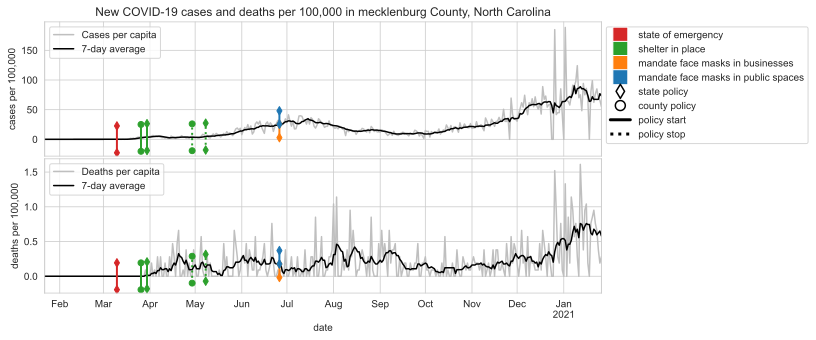

In [45]:
plot_cases_and_policies(county="mecklenburg", state="North Carolina");

# 3 <a id='corr'>Connecting case numbers and covid policies</a>

[back to top](#top)<br>

## 3.1 <a id='3.1'>Finding Correlations</a>

[back to top](#top)<br>

Find the correlation between case / death numbers and policies.

To do this, calculate two quantities related to the number of new cases and number of new deaths: <br>
1) number of new cases / deaths $x$ days after implementation $-$ number of new cases / deaths on the day of implementation. This is will be called the case(death)\_$x$\_day\_delta<br>

2) rate of change of new cases / deaths $x$ days after implementation $-$ rate of change of new cases / deaths on the day of implementation. This will be called the case(death)\_$x$\_day\_accel

In [46]:
def calculate_deltas(measure_period=14, filtered_policies=None, case_df=df, policy_df=df2, state_cases_dict=None): 
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    
    Parameters
    ---------- 
    measure_period : int
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    filtered_policies : array-like 
        specify policies to select (defaul: None- calulate deltas for all policies)
    case_df : pandas DataFrame
        DataFrame with case / death information (default: df)
    policy_df : pandas DataFrame
        DataFrame with police information (default: df2)
    
    Returns
    ----------  
    A copy of the covid policies df (df2) with 2 appended columns for the change in case and death numbers. 
    """
    
    # Initialize wait period before measurement.
    wait_period = timedelta(days=measure_period)
    day_1 = timedelta(days=1)
    
    def sub_calc_deltas(ser, date, wait=wait_period): 
        """Wrap repeated calculations in a sub function to avoid repetition."""
        day_1 = timedelta(days=1)
    
        start      = ser[ser.index==date].values[0]
        start_1day = ser[ser.index==date+day_1].values[0]
        
        end        = ser[ser.index==date+wait].values[0]
        end_1day   = ser[ser.index==date+wait+day_1].values[0]
        
        return [start, start_1day, end, end_1day]
    
    # If there we are only examining select policies, then filter those out.
    if filtered_policies is not None: 
        policy_df = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        
    correlated_df = policy_df.copy()
    
    # Initially fill the delta column with nan.
    correlated_df.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    # Load all state-aggregated datasets into a dictionary. We expect to need all 50 states so let's take the time to aggregate
    # the state data now so we don't need to do it repeatedly in the loop. 
    
    if state_cases_dict is None: 
        state_cases_dict = dict()
        for state in [elem.name for elem in us.states.STATES]: 
            state_cases_dict[state]=get_cases(level="state", state=state);

    case_df = case_df.set_index('date')
    total_policies = len(policy_df)
    
    for index, data in policy_df.iterrows(): 
          
        # If this is a state-level policy, then we already have the DataFrame to use. 
        if data.policy_level == 'state': 
            state_df = state_cases_dict[data.state]
            ser_cases = state_df['new_cases_7day_1e6' ]
            ser_deaths = state_df['new_deaths_7day_1e6']
        
        # This must be a county level policy- filter the appropriate data. 
        else:
            ser_cases = case_df['new_cases_7day_1e6' ][case_df['fips_code'] == data.fips_code]
            ser_deaths = case_df['new_deaths_7day_1e6'][case_df['fips_code'] == data.fips_code]
        
        # Get the case and death numbers at the appropriate days. 
        c11, c12, c21, c22 = sub_calc_deltas(ser_cases, date=data.date)
        d11, d12, d21, d22 = sub_calc_deltas(ser_deaths, date=data.date)
           
        # Calculate the difference in new cases at the selected dates. 
        correlated_df.at[index, f"case_{measure_period}_day_delta"] = c21 - c11
        correlated_df.at[index, f"death_{measure_period}_day_delta"] = d21 - d11
        
        # Calculate the change in curvature (aka acceleration) of the case / death plots at policy implementation and
        # measure_period days afterwards. 
        
        correlated_df.at[index, f"case_{measure_period}_day_accel"] = ((c12-c11) - (c21-c22)) / measure_period
        correlated_df.at[index, f"death_{measure_period}_day_accel"] = ((d12-d11) - (d21-d22)) / measure_period    
    
    
    return correlated_df, state_cases_dict

In [47]:
print("Changes in cases / deaths 14 days after policy implementations:")
policy_deltas, state_cases_dict = calculate_deltas()
policy_deltas.head()

Changes in cases / deaths 14 days after policy implementations:


state     county  fips_code policy_level       date  \
0  Mississippi      hinds      28049       county 2020-07-13   
1      Arizona  statewide          4        state 2020-05-16   
2       Oregon  statewide         41        state 2020-05-15   
5  Connecticut  statewide          9        state 2020-03-16   
6     Michigan  statewide         26        state 2020-03-16   

                policy_type start_stop  \
0             entertainment      start   
1         houses of worship      start   
2  non-essential businesses      start   
5                      gyms      start   
6                      gyms      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
5  Other measures and details for this policy inc...   
6  Other measures and details for this policy inc...   

                                              source  case_14_day_delta  \
0  sip_submission_form: https://www.sos.ms.gov/co...          25.292215   
1  sip_submission_form: https://azgovernor.gov/si...           1.181946   
2  sip_submission_form: https://govstatus.egov.co...          -0.152593   
5                  BU COVID-19 State Policy Database           1.213029   
6                  BU COVID-19 State Policy Database           1.472359   

   case_14_day_accel  death_14_day_delta  death_14_day_accel  
0          -0.105470           -0.119947            0.038111  
1           0.023800           -0.004997            0.000156  
2          -0.002194           -0.021983            0.000098  
5           0.016448            0.019440            0.001281  
6           0.019070            0.060381            0.001331

For every policy that was implemented more than a minimum number of times, aggregate the 4 metrics to get the average (avg) and standard deviation (std). 

In [48]:
def calc_delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    Parameters
    ---------- 
    deltas : pandas DataFrame 
        dataframe of policy deltas on which to do the calculations
    measure_period : int 
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    min_samples : int 
        minimum number of samples that a policy must have for reporting of average and std (default: 10)
    
    Returns
    ----------   
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """
    # Generate a new list of policy types differentiating between start and stop. 
    policy_types = ([elem + " - start" for elem in deltas['policy_type'].unique()]  
                    + [elem + " - stop"  for elem in deltas['policy_type'].unique()])
    
    # Initialize empty arrays for the associated statistics.
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    # Loop through all the policy types.
    for policy in policy_types:
        
        # Determine whether this policy is the beginning or end.  
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
        
        # Get arrays of all the deltas for each type of policy 
        case_data  = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                 (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_accel']
         
        death_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                  (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))
        
        # Calculate the averages and standard deviations for each policy
        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # Construct the dataframe to tabulate the data.
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index=policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # Drop record with less than min_samples samples.
    delta_stats.drop(delta_stats[delta_stats['num_samples'] <= min_samples].index, inplace=True)
    
    return delta_stats

In [49]:
delta_stats = calc_delta_stats(deltas = policy_deltas)
print("Changes in cases and deaths associated with policy implementations:")
delta_stats.head()

<ipython-input-48-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-48-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-48-715a146e52e3>:58: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-48-715a146e52e3>:59: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


Changes in cases and deaths associated with policy implementations:


case_avg  case_accel_avg  death_avg  \
entertainment - start                2.589929       -0.027899  -0.035841   
houses of worship - start            3.430665       -0.076693  -0.040953   
non-essential businesses - start     4.482265        0.067338  -0.058647   
gyms - start                         2.445999        0.023406   0.067237   
allow audio only telehealth - start  3.229401        0.020830   0.147806   

                                     death_accel_avg   case_std  \
entertainment - start                      -0.000898  11.818583   
houses of worship - start                  -0.002550  18.165869   
non-essential businesses - start           -0.000285  14.647177   
gyms - start                                0.000573   3.421345   
allow audio only telehealth - start         0.001149   5.274714   

                                     case_accel_std  death_std  \
entertainment - start                      0.269728   0.475786   
houses of worship - start                  0.415597   0.649061   
non-essential businesses - start           0.587288   0.452990   
gyms - start                               0.068249   0.237476   
allow audio only telehealth - start        0.051617   0.260551   

                                     death_accel_std  num_samples  
entertainment - start                       0.023427        149.0  
houses of worship - start                   0.035915         77.0  
non-essential businesses - start            0.021072        181.0  
gyms - start                                0.002697         49.0  
allow audio only telehealth - start         0.003338         45.0

The "Mean of empty slice" warnings may be safely ignored. These correspond to policies that were never implemented. For example, many countries started 'allow audio only telehealth', but no county or state has stopped such a policy. 

## 3.2 <a id='3.2'>Evaluating Correlations</a>

[back to top](#top)<br>

Plot the 4 metrics as associated variances for each policy 3, 7, 10, 14 and 21 days after a given policy implementation to evaluate how well this model performs.

In [50]:
def eval_delta_stats(delta_stats, num_days=14, interval='std'):
    
    # force interval to std 
    interval = 'std'
    fig, ax = plt.subplots(ncols=4, figsize=[10, 15], sharey=True)

    def eval_color(num, error): 
        if num+error<0: 
            return 'g'
        elif num-error>0: 
            return 'r'
        else: 
            return 'k'

    for i, index in enumerate(delta_stats.index): 
        vals     = delta_stats.loc[index][ :4].values
        vals_std = delta_stats.loc[index][4:-1].values
        n = delta_stats.loc[index][-1]

        for j, (val, val_std) in enumerate(zip(vals, vals_std)):  
    
            # if interval is 'std', set the errorbar to the same width as the std
            if interval == 'std': 
                err = val_std
            # if a confidence interval is specified, set error bar to with width of the desired CI
            else: 
                # Since the population variance is unkown, use the t-score (two-tail)
                # This method is still under development
                t = stats.t.ppf(1-(interval/2), n)
                err = (val + t*(val_std / math.sqrt(n)))
            
            ax[j].errorbar(y=i, 
                        x=val, 
                        xerr=err,
                        marker='.',
                        markersize=15,
                        capsize=5,
                        linewidth=3,
                        linestyle='None',
                        c=eval_color(val, err)
                       )
    titles = ["new cases", "acceleration of new cases", "new deaths", "acceleration of new deaths"]
    for i in range(4):
        lims = ax[i].get_ylim()
        ax[i].vlines(x=0, ymin=lims[0], ymax=lims[1], color='k')
        ax[i].set_ylim(lims)
        ax[i].set_title(titles[i])
        ax[i].tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.yticks(range(len(delta_stats.index)), delta_stats.index, fontsize=8)
    if interval == 'std':
        title = f"Correlations in covid policy metrics {num_days} days after implementation (errorbar = std)"
    else: 
        title = f"Correlations in covid policy metrics {num_days} days after implementation (CI = {interval})"
    plt.suptitle(title, y=0.95);

<ipython-input-48-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-48-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-48-715a146e52e3>:58: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-48-715a146e52e3>:59: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
<ipython-input-48-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-48-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anac

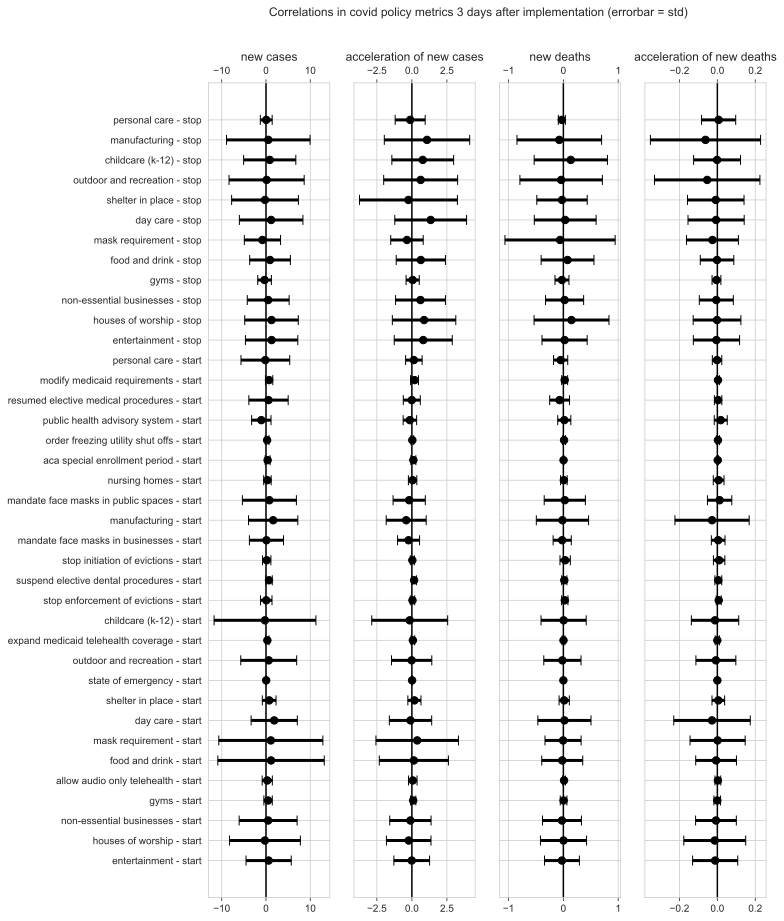

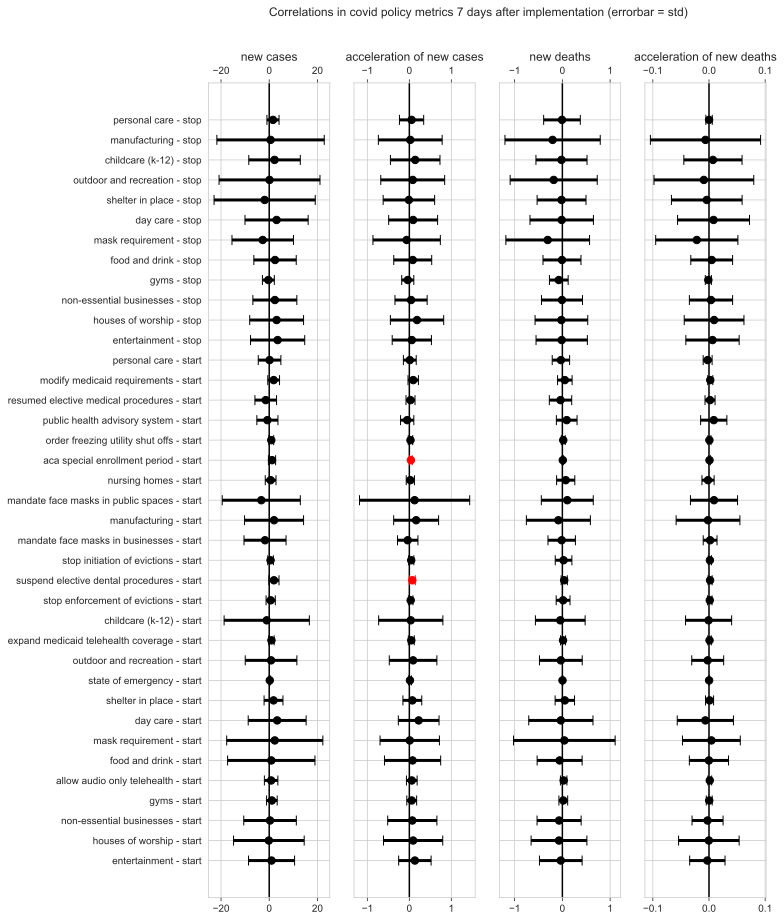

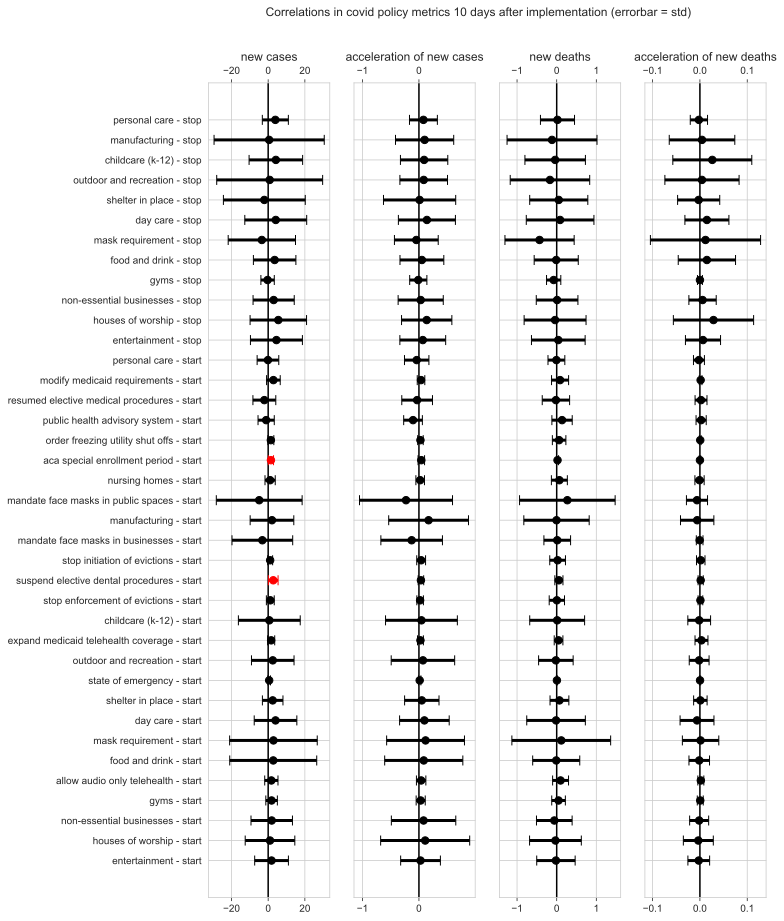

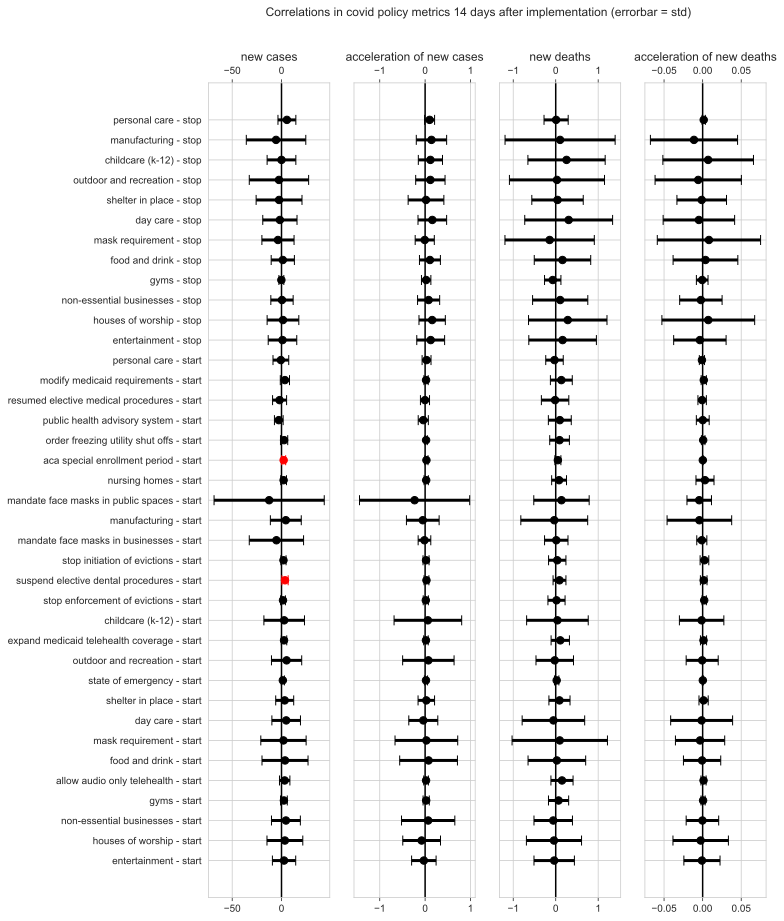

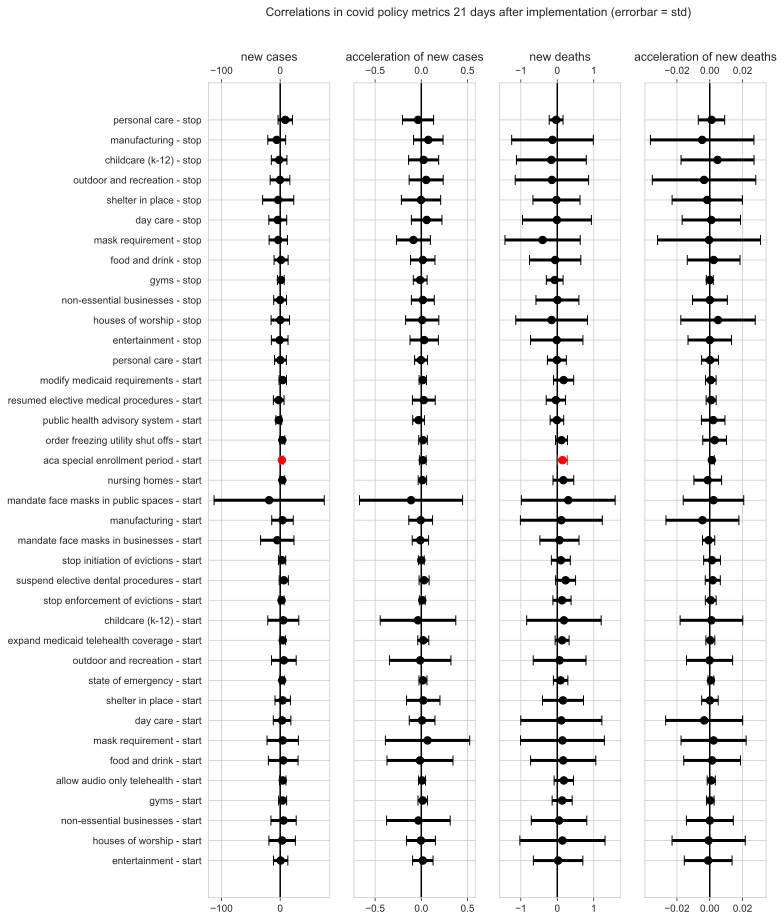

In [51]:
days = [3, 7, 10, 14, 21]
state_cases_dict = None
for day in days: 
    deltas, state_cases_dict = calculate_deltas(measure_period=day, state_cases_dict=state_cases_dict)
    
    eval_delta_stats(calc_delta_stats(deltas=deltas, measure_period=day), 
                     num_days=day)

## 3.3 <a id='3.3'>Discussion</a>
[back to top](#top)<br>


Most of these policies don't definitvely correlate to an increase or decrease in case / death numbers. The exceptions are 'aca special enrollment period - start' (7 day and 10 day increase in  case acceleration, 14 day increase in new cases, and 21 day increase in new cases and new deaths) and 'suspend elective dental procedures - start' (7 day acceleration in new cases and 10 and 14 day increase in new cases)

It is difficult to judge the actual impacts that these policies had based on these visualizations, since these case and death numbers were influenced by a large number of variables, most notably other policy implementations, but also other environmental and societal factors. 

To better quantify how these policies may have impacted the number of cases and deaths, it is necessary to uncouple multiple policy implementations, which calls for a multilinear regression algorithm.

This regression step is currently in development. To see the updates, please see [this notebook](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/dev2/Covid-19%20data%20analysis.ipynb#3.4) on the dev2 branch. For further reading, this project is similar to the research by [Kimlek et al](https://www.nature.com/articles/s41562-020-01009-0?fbclid=IwAR2fnHNxYtB54oHuyQmz8rEpuypgwvbWvSnY8fOQg7Zt_bLA13HsZZvecrY), which used multiple techniques to quantify the impact of worldwide policy implementations. 

# 4. <a id='4'>Conclusion</a>

[back to top](#top)<br>

To summarize, we cleaned 2 datasets: one on the covid-19 case and death numbers and another on the policy data. We plotted the case data at the country and state level and correlated those with policy implementations. Finally, we more elegantly correlated the policies with case data by aggregating all the policy implementations to get a measure on the change in cases and deaths, as well as how fast those case and death numbers are changing (acceleration).